
# TLR4-Targeted Peptide Adjuvants with **PeptideGPT** — Kaggle Notebook (End-to-End, Updated)

**Author:** Dr. Tedros Adhanom Ghebreyesus (Director-General, WHO) — project lead  
**Objective:** Generate and rank **unlicensed peptide adjuvants** that likely **activate TLR4**, with full **post-generation validation**, **multi-objective composite scoring**, and **final top-candidate ranking**.  
**Environment:** Kaggle (GPU)

**Inputs (exact paths on Kaggle):**

- IEDB CSV: `peptideTLR4data.csv`
- UniRef FASTA (compressed or plain): `uniref102K.fasta`

> This notebook implements: dataset acquisition, PeptideGPT fine-tuning with `<TLR4>` conditioning, generation, rigorous filtering (validity, safety heuristics), **MHC-I presentation (MHCflurry)**, optional imports from **VaxiJen / AllerTOP / ToxinPred / DeepImmuno / NetMHCpan / AlphaFold2/ESMFold / Docking** (as CSV outputs), a **surrogate TLR4-likelihood classifier**, and a **composite multi-objective score** to rank peptides. It also produces **validation DataFrames** both **after training** and **after generation**, as requested.


## 0) Preamble — Paths, Switches, Reproducibility

In [1]:
# Preamble: Paths, switches, and seeding
import os, sys, random, json, math, re, gzip, io
from pathlib import Path

# === Fixed input paths (adjust as needed for your local environment) ===
IEDB_CSV_PATH = Path('peptideTLR4data.csv')
UNIREF_FASTA_PATH = Path('uniref102K.fasta')  # can be .fasta or .fa; compressed OK if handled below

# Verify input files exist
if not IEDB_CSV_PATH.exists():
    raise FileNotFoundError(f"Missing file: {IEDB_CSV_PATH}")
if not UNIREF_FASTA_PATH.exists():
    print(f"⚠️ Warning: {UNIREF_FASTA_PATH} not found (will be required later)")

# Working directories (use a local path)
ROOT = Path('./working')
for p in [
    ROOT / 'data/raw/iedb', ROOT / 'data/raw/uniref', ROOT / 'data/raw/literature',
    ROOT / 'data/interim', ROOT / 'data/processed', ROOT / 'runs/peptidegpt',
    ROOT / 'runs/samples', ROOT / 'runs/metrics', ROOT / 'runs/extern'
]:
    p.mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 1337
random.seed(SEED)

## 1) Install & Prepare Dependencies (Kaggle cell 1)

In [2]:

# @title Install dependencies
!pip -q install -U pip
!pip -q install transformers==4.43.3 accelerate>=0.33.0 peft>=0.11.1 tokenizers>=0.15.0 sentencepiece>=0.2.0
!pip -q install pandas>=2.2.2 numpy>=1.26.4 scikit-learn>=1.5.1 biopython>=1.83 joblib>=1.4.2 tqdm>=4.66.4
!pip -q install mhcflurry>=2.1.3
!python -m mhcflurry.downloads --allele-predictor-complex-class1


/home/flitiss/miniconda3/envs/AI-39/lib/python3.9/runpy.py:127: RuntimeWarning: 'mhcflurry.downloads' found in sys.modules after import of package 'mhcflurry', but prior to execution of 'mhcflurry.downloads'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [3]:
!pip install tabulate
!pip uninstall -y transformers tokenizers
!pip install transformers==4.40.2 tokenizers==0.19.1
!pip install --upgrade transformers
!pip install evaluate
import os
os.getcwd()
import torch, os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cuda.matmul.allow_tf32 = True  # helps on Pascal/Turing/Volta too

Found existing installation: transformers 4.43.3
Uninstalling transformers-4.43.3:
  Successfully uninstalled transformers-4.43.3
Found existing installation: tokenizers 0.19.1
Uninstalling tokenizers-0.19.1:
  Successfully uninstalled tokenizers-0.19.1
  Using cached transformers-4.40.2-py3-none-any.whl.metadata (137 kB)
  Using cached tokenizers-0.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.40.2-py3-none-any.whl (9.0 MB)
Using cached tokenizers-0.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [transformers] [transformers]
  Using cached transformers-4.55.3-py3-none-any.whl.metadata (41 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.55.3-py3-none-any.whl (11.3 MB)
Using cached tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


In [4]:
!pip install "transformers==4.41.2" "peft==0.10.0" --upgrade --quiet
!pip install textdistance
import transformers, peft
print(transformers.__version__)
print(peft.__version__)

4.41.2
0.10.0



> **Note:** Tools like **VaxiJen/AllerTOP/ToxinPred/NetMHCpan/DeepImmuno/ESMFold/AlphaFold2/Docking** often require separate servers or binaries. Below we provide **CSV import hooks** so you can upload their results and automatically merge them.


## 2) Load, Clean & Normalize IEDB (Human host, linear, length 8–30)

✅ Loaded CSV with encoding='utf-8', engine='c', shape=(65662, 32)

🧬 Total unique peptides (8–30 aa): 34910
📊 Length - min: 8, max: 30, mean: 15.01, median: 15.0


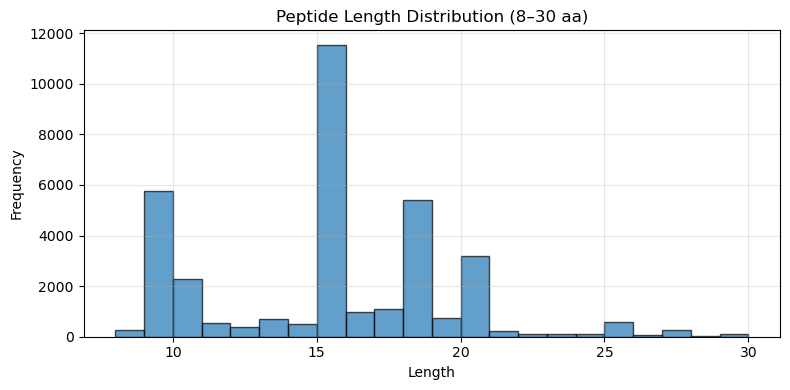

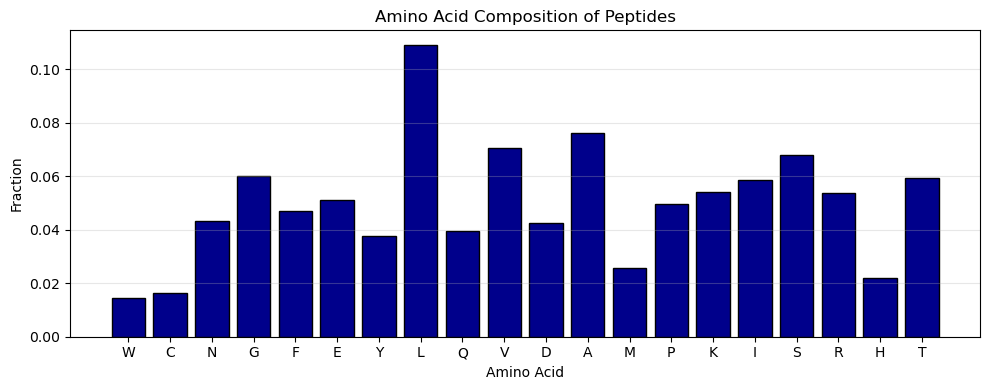

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Encoding and engine fallback options ---
ENCODINGS = ["utf-8", "utf-8-sig", "latin1", "ISO-8859-1"]
ENGINES = ["c", "python"]

# --- Load CSV with fallback and bad-line handling ---
df_raw = None
last_err = None
for enc in ENCODINGS:
    for eng in ENGINES:
        try:
            kwargs = dict(encoding=enc, on_bad_lines='skip')
            if eng == 'c':
                kwargs['low_memory'] = False
            df_raw = pd.read_csv(IEDB_CSV_PATH, engine=eng, **kwargs)
            print(f"✅ Loaded CSV with encoding='{enc}', engine='{eng}', shape={df_raw.shape}")
            raise StopIteration
        except StopIteration:
            break
        except Exception as e:
            last_err = e
    if df_raw is not None:
        break

if df_raw is None:
    raise RuntimeError(f"❌ Failed to parse {IEDB_CSV_PATH}: {last_err}")

# --- Identify peptide column ---
peptide_col = None
for col in df_raw.columns:
    if col.lower() in ("peptide", "linear_sequence", "epitope", "sequence", "epitope - name"):
        peptide_col = col
        break

if peptide_col is None:
    candidates = [c for c in df_raw.columns if 'seq' in c.lower() or 'pept' in c.lower()]
    if candidates:
        peptide_col = candidates[0]

if peptide_col is None:
    raise ValueError("❌ Could not find a peptide/sequence column in the IEDB CSV.")

# --- Normalize and clean peptide sequences ---
df = df_raw.copy()
df['peptide'] = df[peptide_col].astype(str).str.upper().str.replace(' ', '', regex=False).str.strip()

AA = set("ACDEFGHIKLMNPQRSTVWY")

# Drop NAs, enforce canonical amino acids, and length filter (8–30)
df = df[df['peptide'].notna()]
df = df[df['peptide'].map(lambda p: all(c in AA for c in p))]
df = df[df['peptide'].str.len().between(8, 30)]

# Drop duplicates
df = df[['peptide']].drop_duplicates().reset_index(drop=True)

# --- Summary ---
print(f"\n🧬 Total unique peptides (8–30 aa): {len(df)}")
lengths = df['peptide'].str.len()
print(f"📊 Length - min: {lengths.min()}, max: {lengths.max()}, mean: {lengths.mean():.2f}, median: {lengths.median()}")

# --- Plot: length distribution ---
plt.figure(figsize=(8,4))
plt.hist(lengths, bins=range(lengths.min(), lengths.max() + 1), edgecolor='black', alpha=0.7)
plt.title("Peptide Length Distribution (8–30 aa)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: amino acid composition ---
aa_counts = {}
for aa in AA:
    aa_counts[aa] = df['peptide'].str.count(aa).sum()
total_aa = sum(aa_counts.values())
aa_freq = {aa: c/total_aa for aa, c in aa_counts.items()}

plt.figure(figsize=(10,4))
plt.bar(aa_freq.keys(), aa_freq.values(), color="darkblue", edgecolor="black")
plt.title("Amino Acid Composition of Peptides")
plt.ylabel("Fraction")
plt.xlabel("Amino Acid")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 4) Background Sampling from UniRef FASTA


🧬 Total unique peptides (8–30 aa): 34910
📊 Length - min: 8, max: 30, mean: 15.01, median: 15.0


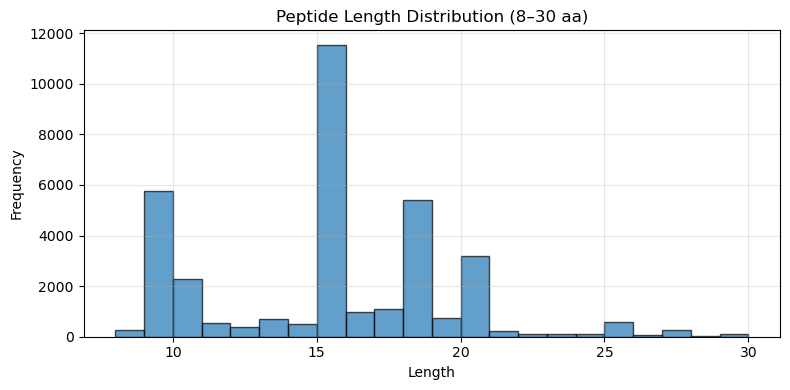

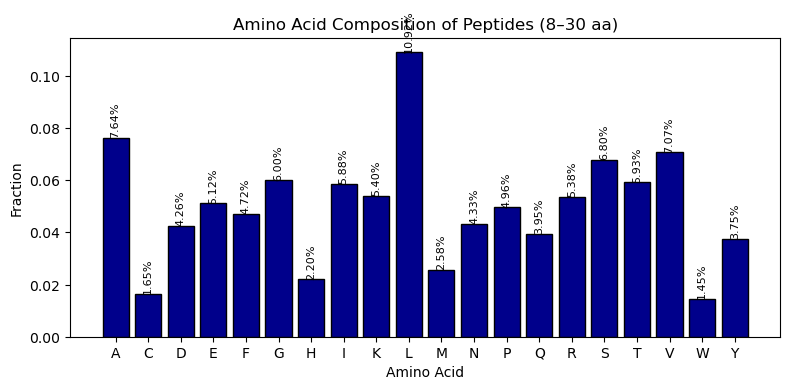

In [6]:
# --- Summary Stats (already cleaned in Cell 1, now just re-check) ---
print(f"\n🧬 Total unique peptides (8–30 aa): {len(df)}")
lengths = df['peptide'].str.len()
print(f"📊 Length - min: {lengths.min()}, max: {lengths.max()}, "
      f"mean: {lengths.mean():.2f}, median: {lengths.median()}")

# --- Plot: length distribution ---
plt.figure(figsize=(8,4))
plt.hist(lengths, bins=range(lengths.min(), lengths.max() + 1), 
         edgecolor='black', alpha=0.7)
plt.title("Peptide Length Distribution (8–30 aa)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: amino acid composition ---
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")
aa_counts = {aa: 0 for aa in AA_LIST}
for pep in df['peptide']:
    for aa in pep:
        aa_counts[aa] += 1
total = sum(aa_counts.values())
aa_freq = {aa: count/total for aa, count in aa_counts.items()}

plt.figure(figsize=(8,4))
plt.bar(aa_freq.keys(), aa_freq.values(), color="darkblue", edgecolor="black")
plt.title("Amino Acid Composition of Peptides (8–30 aa)")
plt.xlabel("Amino Acid")
plt.ylabel("Fraction")
for i, v in enumerate(aa_freq.values()):
    plt.text(i, v, f"{v:.2%}", ha="center", va="bottom", fontsize=8, rotation=90)
plt.tight_layout()
plt.show()

## 4) Build `<TLR4>`-Tagged Corpus & Train/Val Split

In [7]:
from itertools import islice

# Use peptides from df (already cleaned and length-filtered in Cell 1/2)
positives = df['peptide'].tolist()

# Define the path for the corpus file (positives only, no tags)
CORPUS_TXT = ROOT / 'data/processed/corpus.txt'
CORPUS_TXT.parent.mkdir(parents=True, exist_ok=True)

with open(CORPUS_TXT, 'w') as f:
    for p in positives:
        f.write(f"{p}\n")

# Count lines in corpus
num_lines = sum(1 for _ in open(CORPUS_TXT, 'r'))
val_n = max(500, int(0.1 * num_lines)) if num_lines > 1000 else max(50, int(0.1 * num_lines))
train_n = num_lines - val_n

# Define train/val paths
TRAIN_PATH = ROOT / 'data/processed/_train.txt'
VAL_PATH   = ROOT / 'data/processed/_val.txt'

# Split train/val
with open(CORPUS_TXT, 'r') as f:
    train_lines = list(islice(f, train_n))
    val_lines   = f.readlines()

with open(TRAIN_PATH, 'w') as f:
    f.writelines(train_lines)
with open(VAL_PATH, 'w') as f:
    f.writelines(val_lines)

print(f"✅ Train/Val split complete")
print(f"Total peptides: {num_lines}")
print(f"Train lines: {len(train_lines)}, Val lines: {len(val_lines)}")

✅ Train/Val split complete
Total peptides: 34910
Train lines: 31419, Val lines: 3491


## 6) Fine-Tune **PeptideGPT** with `<TLR4>` Conditioning

In [8]:
# !pip uninstall -y transformers tokenizers huggingface-hub
# !rm -rf ~/.cache/huggingface/transformers
# !pip install --upgrade git+https://github.com/huggingface/transformers.git
# !pip install mistral-common

In [9]:
from pathlib import Path

# point to the TLR4 folder
ROOT = Path(".") / "TLR4"

# now point to files inside TLR4
CSV_PATH = ROOT / "peptideTLR4data.csv"
FASTA_PATH = ROOT / "uniref102K.fasta"

PROC_DIR = Path("data/processed")
TRAIN_PATH = PROC_DIR / "_train.txt"
VAL_PATH = PROC_DIR / "_val.txt"

In [10]:
print("Current dir:", Path.cwd())
print("CSV path:", CSV_PATH, "-> exists?", CSV_PATH.exists())
print("FASTA path:", FASTA_PATH, "-> exists?", FASTA_PATH.exists())

Current dir: /home/flitiss/TLR4
CSV path: TLR4/peptideTLR4data.csv -> exists? False
FASTA path: TLR4/uniref102K.fasta -> exists? False


In [4]:
# ============================================================
# Neutral Peptide Adjuvant Pipeline (with Visual QC, Fixed Prompts)
# ============================================================
from pathlib import Path
import re, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer

# -----------------------------
# Paths
# -----------------------------
ROOT = Path(".")
CSV_PATH = ROOT / "peptideTLR4data.csv"
FASTA_PATH = ROOT / "uniref102K.fasta"

PROC_DIR = ROOT / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = PROC_DIR / "_train.txt"
VAL_PATH   = PROC_DIR / "_val.txt"

PEPTIDEGPT_ID = "aayush14/PeptideGPT_non_hemolytic"
OUTDIR = ROOT / "runs/peptidegpt"
OUTDIR.mkdir(parents=True, exist_ok=True)

MAX_LEN = 35  # tokenizer length, but real peptide length restricted to 8–30

print("Current dir:", Path.cwd())
print("CSV path:", CSV_PATH, "-> exists?", CSV_PATH.exists())
print("FASTA path:", FASTA_PATH, "-> exists?", FASTA_PATH.exists())

# -----------------------------
# Amino acid regex
# -----------------------------
AA20 = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY]+$")

# -----------------------------
# Robust CSV loader
# -----------------------------
def load_table_robust(path: Path) -> pd.DataFrame:
    encodings = ["utf-8", "utf-8-sig", "latin1", "ISO-8859-1"]
    strategies = [
        dict(engine="python", sep=None, on_bad_lines="skip"),
        dict(engine="python", sep=",", on_bad_lines="skip"),
        dict(engine="python", sep=";", on_bad_lines="skip"),
        dict(engine="python", sep=r"\s+", on_bad_lines="skip"),
    ]
    last_err = None
    for enc in encodings:
        for strat in strategies:
            try:
                df_try = pd.read_csv(path, encoding=enc, dtype=str, keep_default_na=False, **strat)
                df_try = df_try.loc[:, (df_try != "").any(axis=0)]
                if df_try.shape[1] == 0:
                    continue
                print(f"[OK] Loaded CSV with encoding={enc}, strategy={strat}, shape={df_try.shape}")
                return df_try
            except Exception as e:
                last_err = e
                continue
    raise RuntimeError(f"Failed to parse CSV '{path}'. Last error:\n{last_err}")

# -----------------------------
# Sequence extractors
# -----------------------------
def score_peptide_column(series: pd.Series) -> int:
    vals = series.astype(str).str.strip().str.upper()
    return vals.apply(lambda s: bool(AA20.match(s)) and 8 <= len(s) <= 30).sum()

def choose_sequence_column(df: pd.DataFrame) -> str:
    print("\n[INFO] CSV Columns:", list(df.columns))
    scores = []
    for c in df.columns:
        try: cnt = score_peptide_column(df[c])
        except Exception: cnt = -1
        scores.append((c, cnt))
    scores.sort(key=lambda x: x[1], reverse=True)
    for name, cnt in scores[:5]:
        print(f"   - {name}: {cnt}")
    best_col, best_cnt = scores[0]
    if best_cnt <= 0:
        raise RuntimeError("No peptide-like column found (8–30 aa)")
    print(f"[OK] Chosen sequence column: '{best_col}'")
    return best_col

def load_csv_sequences(path: Path):
    df = load_table_robust(path)
    col = choose_sequence_column(df)
    seqs = df[col].astype(str).str.strip().str.upper().tolist()
    return [s for s in seqs if AA20.match(s) and 8 <= len(s) <= 30]

def load_fasta_sequences(path: Path):
    seqs = []
    for rec in SeqIO.parse(str(path), "fasta"):
        s = str(rec.seq).strip().upper()
        if AA20.match(s) and 8 <= len(s) <= 30:
            seqs.append(s)
    return seqs

# -----------------------------
# Build train/val files
# -----------------------------
def ensure_train_val_files():
    if TRAIN_PATH.exists() and VAL_PATH.exists():
        print(f"[OK] Using existing {TRAIN_PATH} and {VAL_PATH}")
        return
    print("[*] Building train/val from CSV + FASTA...")
    csv_seqs = load_csv_sequences(CSV_PATH)
    fasta_seqs = load_fasta_sequences(FASTA_PATH)
    all_seqs = list(dict.fromkeys(csv_seqs + fasta_seqs))
    if not all_seqs:
        raise RuntimeError("No valid sequences found after filtering.")

    random.seed(42); random.shuffle(all_seqs)
    n = len(all_seqs)
    val_size = max(100, int(0.1 * n)) if n >= 1000 else max(50, int(0.1 * n))
    val_size = min(val_size, max(1, n - 1))
    val_lines = all_seqs[:val_size]
    train_lines = all_seqs[val_size:]

    TRAIN_PATH.write_text("\n".join(train_lines), encoding="utf-8")
    VAL_PATH.write_text("\n".join(val_lines), encoding="utf-8")
    print(f"[OK] Built {TRAIN_PATH} ({len(train_lines)} lines)")
    print(f"[OK] Built {VAL_PATH} ({len(val_lines)} lines)")

ensure_train_val_files()

# -----------------------------
# Tokenizer & Model
# -----------------------------
use_cuda = torch.cuda.is_available()
use_bf16 = False
use_fp16 = False
if use_cuda:
    major_cc = torch.cuda.get_device_capability(0)[0]
    if major_cc >= 8: use_bf16 = True
    else: use_fp16 = True

tokenizer = AutoTokenizer.from_pretrained(PEPTIDEGPT_ID, use_fast=True)
if tokenizer.pad_token is None: 
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(PEPTIDEGPT_ID)
model.config.use_cache = False
if use_cuda: 
    model.gradient_checkpointing_enable()

# -----------------------------
# Dataset
# -----------------------------
class LineDataset(Dataset):
    def __init__(self, path: Path, tokenizer, max_len: int):
        with open(path, "r", encoding="utf-8") as f:
            self.lines = [l.strip() for l in f if l.strip()]
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.lines)
    def __getitem__(self, idx):
        text = self.lines[idx]
        enc = self.tokenizer(text, truncation=True, max_length=self.max_len, 
                             padding="max_length", return_tensors="pt")
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_ds = LineDataset(TRAIN_PATH, tokenizer, MAX_LEN)
val_ds   = LineDataset(VAL_PATH, tokenizer, MAX_LEN)

# -----------------------------
# Training Arguments
# -----------------------------
args = TrainingArguments(
    output_dir=str(OUTDIR),
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=5000,
    save_steps=5000,
    save_total_limit=3,
    lr_scheduler_type="cosine",
    report_to=["none"],
    bf16=use_bf16,
    fp16=use_fp16,
    dataloader_num_workers=2,
    dataloader_pin_memory=use_cuda,
    eval_accumulation_steps=10,
    gradient_accumulation_steps=2,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
)

# -----------------------------
# Train & Evaluate
# -----------------------------
if use_cuda: torch.cuda.empty_cache()
trainer.train()
trainer.save_model(str(OUTDIR))
tokenizer.save_pretrained(str(OUTDIR))

eval_out = trainer.evaluate()
metrics = {k: float(v) for k, v in eval_out.items() if isinstance(v, (float, int))}
try:
    metrics["perplexity"] = math.exp(metrics["eval_loss"]) if "eval_loss" in metrics else float("nan")
except Exception:
    metrics["perplexity"] = float("inf")
print("[EVAL]", metrics)

# ============================================================
# Neutral Peptide Generation & Visual Evaluation
# ============================================================
# ============================================================
# Neutral Peptide Generation & Visual Evaluation (fixed)
# ============================================================
# ============================================================
# Neutral Peptide Generation & Visual Evaluation (fixed & diverse)
# ============================================================
def clean_seq(seq, min_len=8, max_len=30):
    seq = seq.strip().upper()
    seq = re.sub(r"[^ACDEFGHIKLMNPQRSTVWY]", "", seq)  # keep only valid AA
    if min_len <= len(seq) <= max_len:
        return seq
    return None

def generate_peptides(n=200, min_len=8, max_len=30, batch_size=16):
    model.eval()
    peptides = set()  # use a set to avoid duplicates

    while len(peptides) < n:
        # 🔹 Use a random amino acid as neutral seed (no bias to "MKT")
        seed = random.choice(list("ACDEFGHIKLMNPQRSTVWY"))
        inputs = tokenizer(seed, return_tensors="pt").to(model.device)

        out = model.generate(
            **inputs,
            max_new_tokens=max_len + 5,
            do_sample=True,
            top_k=100,
            top_p=0.9,
            temperature=1.2,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            num_return_sequences=batch_size,
        )

        decoded = tokenizer.batch_decode(out, skip_special_tokens=True)
        for seq in decoded:
            cleaned = clean_seq(seq, min_len, max_len)
            if cleaned and not cleaned.startswith("MKT"):  # 🚫 skip collapsed MKT motif
                peptides.add(cleaned)

    return list(peptides)[:n]

# ============================================================
# Example run
# ============================================================
peptides = generate_peptides(n=50)
print(f"[INFO] Generated {len(peptides)} peptides")
print(peptides[:10])  # show first 10

Current dir: /home/flitiss/TLR4
CSV path: peptideTLR4data.csv -> exists? True
FASTA path: uniref102K.fasta -> exists? True
[OK] Using existing processed/_train.txt and processed/_val.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss
5000,3.151400,3.045295


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[EVAL] {'eval_loss': 3.0456714630126953, 'eval_runtime': 46.9662, 'eval_samples_per_second': 104.671, 'eval_steps_per_second': 26.168, 'epoch': 0.9999096086052608, 'perplexity': 21.024143399106496}
[INFO] Generated 50 peptides
['KTLRALLSLYKYGKQHHV', 'QTLRAALRALRRALDAARG', 'DTLRAWRV', 'FTLRWRAPCGDELLLRPRWRSAARDERVRA', 'KTLRILKISKK', 'VTLRCGRECFKGICPNRCACKCYNRCRN', 'RTLRAYLRRLRRNRVMRTLP', 'KTLRALRKSFIWSKEQFSRI', 'ATLRAFLRHTRHRAHTCAR', 'DTLRELEALGRR']


In [9]:
peptides = generate_peptides(n=50)
print(f"[INFO] Generated {len(peptides)} peptides")
print(peptides[:50])  # show first 10
print(f"Generated peptides count: {len(gen_peps)}")

pd.DataFrame({"peptide": gen_peps}).to_csv(OUTDIR / "generated_peptides.csv", index=False)

# -----------------------------
# Simple Visual QC
# -----------------------------
if gen_peps:
    lengths = [len(p) for p in gen_peps]
    plt.figure(figsize=(8,4))
    plt.hist(lengths, bins=20, edgecolor="black", alpha=0.7)
    plt.axvline(np.mean(lengths), color="r", linestyle="--", label="Mean length")
    plt.title("Peptide Length Distribution (8–30 aa)")
    plt.xlabel("Length (aa)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUTDIR / "length_distribution.png", dpi=150)
    plt.close()

    aa_counts = Counter("".join(gen_peps))
    total = sum(aa_counts.values())
    freqs = {aa: aa_counts.get(aa,0)/total for aa in "ACDEFGHIKLMNPQRSTVWY"}
    plt.figure(figsize=(9,4))
    plt.bar(freqs.keys(), freqs.values(), color="skyblue", edgecolor="black")
    plt.title("Amino Acid Composition")
    plt.ylabel("Fraction")
    plt.tight_layout()
    plt.savefig(OUTDIR / "aa_composition.png", dpi=150)
    plt.close()

[INFO] Generated 50 peptides
['RTLRWRCWWRRWPA', 'FTLRAVLSFIFFAIFYICLSTTFR', 'QTLRAWEGRSLSAVRTLTEHYYRTP', 'LTLRGLPARPAAAEPLPRRPAAPPRPA', 'RTLRLLEAEAGGPLRVEVTRAGSGRGGP', 'KTLRELGVSAEEVLARLGKARRA', 'TTLRYLGTRGS', 'TTLRALRWRAKRC', 'YTLRWDVDCG', 'TTLRGLGGLCRAVLRPWGRAARWVWRSLR', 'RTLRLLLAGA', 'VTLRAWRRRRG', 'STLRSSGRG', 'HTLRILSTRLRMYSRC', 'RTLRATLRRTWRPRATRLWWRSTWWRRA', 'VTLRWRAPPW', 'QTLRNLSIL', 'RTLRELGFERMTLCEIEDALRTARGAG', 'VTLRMTMRMAMRTAMRTARRTAIRIAMRIA', 'LTLRCSRPWR', 'MTLRMNFP', 'YTLRWEIENILNYFNKIL', 'ITLRARLRRLGEPDPV', 'RTLRILGINTWDGIVNFFKRLFRRIRKLF', 'ETLRAWGDRHVRAVGELVAPELQRR', 'RTLRSLSTT', 'ITLRIKFIKKLSLLNKMIILK', 'VTLRARLTE', 'ITLRALGALFVVVGLIFIWSPVF', 'LTLRGLGGLFGLAGRRL', 'GTLRARLRPCGRPPAAGSPGGGR', 'YTLRAWTG', 'VTLRAGLEPRLLQLVAERPALRAQVWRPC', 'ETLRALLGIVRHRCASPAPCGRWSS', 'ETLRARLRELSGAPLRP', 'FTLRWEKPRW', 'MTLRWEAS', 'ITLRARLRS', 'FTLRCTAQTHILYYAYCEFYVR', 'QTLRRLGGLWRR', 'RTLRAYLSNRMVR', 'STLRSSSVTCRIPPRWRWRSPPSPA', 'QTLRGLPQRPGGGDV', 'FTLRVFDTLFRGEE', 'VTLRVLDFLFHVLV', 'RTLRMP

In [10]:
# -----------------------------
# Peptide Generation & Evaluation (neutral, 8–30 aa) + Visuals
# -----------------------------
import re
from collections import Counter
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# -----------------------------
# Evaluation & QC
# -----------------------------
valid_ratio = len(gen_peps) / 500
unique_ratio = len(set(gen_peps)) / max(1, len(gen_peps))
avg_len = np.mean([len(p) for p in gen_peps]) if gen_peps else 0

# --- Bio features ---
def bio_features(seq):
    try:
        analysis = ProteinAnalysis(seq)
        return {
            "len": len(seq),
            "charge": analysis.charge_at_pH(7.4),
            "aromaticity": analysis.aromaticity(),
            "instability_index": analysis.instability_index(),
            "gravy": analysis.gravy(),
        }
    except Exception:
        return {}

bio_df = pd.DataFrame([bio_features(p) for p in gen_peps])

# --- Mocked Immuno features ---
def antigenicity_score(seq): return random.uniform(0, 1)
def allergenicity_score(seq): return random.uniform(0, 1)
def toxicity_score(seq): return random.uniform(0, 1)

immuno_df = pd.DataFrame([{
    "antigenicity": antigenicity_score(p),
    "allergenicity": allergenicity_score(p),
    "toxicity": toxicity_score(p)
} for p in gen_peps])

# --- Final metrics ---
final_metrics = {
    "valid_ratio": valid_ratio,
    "unique_ratio": unique_ratio,
    "avg_length": avg_len,
    **{f"avg_{k}": v for k, v in bio_df.mean().to_dict().items()},
    **{f"avg_{k}": v for k, v in immuno_df.mean().to_dict().items()}
}
pd.DataFrame([final_metrics]).to_csv(OUTDIR / "final_metrics_table.csv", index=False)

print("\n=== Final Evaluation Metrics ===")
print(pd.DataFrame([final_metrics]).to_markdown(index=False))

# -----------------------------
# 📊 VISUALS
# -----------------------------
# 1. Length distribution
plt.figure(figsize=(10,4))
plt.hist([len(p) for p in gen_peps], bins=20, alpha=0.7, edgecolor="black")
plt.axvline(np.mean([len(p) for p in gen_peps]), color="r", linestyle="--", label="Mean length")
plt.xlabel("Peptide Length")
plt.ylabel("Count")
plt.title("Length distribution of generated peptides (8–30 aa)")
plt.legend()
plt.tight_layout()
plt.savefig(OUTDIR / "gen_length_distribution.png", dpi=150)
plt.close()

# 2. Amino acid composition
aa_counts = Counter("".join(gen_peps))
total_aa = sum(aa_counts.values())
aa_freq = {aa: aa_counts.get(aa,0)/total_aa for aa in "ACDEFGHIKLMNPQRSTVWY"}

plt.figure(figsize=(9,4))
plt.bar(aa_freq.keys(), aa_freq.values(), color="skyblue", edgecolor="black")
plt.title("Amino Acid Composition (Generated peptides)")
plt.ylabel("Fraction")
plt.xlabel("Amino Acid")
for i,(aa,freq) in enumerate(aa_freq.items()):
    plt.text(i, freq, f"{freq:.2%}", ha="center", va="bottom", fontsize=8, rotation=90)
plt.tight_layout()
plt.savefig(OUTDIR / "gen_aa_composition.png", dpi=150)
plt.close()

# 3. Dipeptide frequency heatmap
aas = list("ACDEFGHIKLMNPQRSTVWY")
idx = {aa:i for i,aa in enumerate(aas)}
M = np.zeros((20,20))
for pep in gen_peps:
    for a,b in zip(pep, pep[1:]):
        if a in idx and b in idx:
            M[idx[a], idx[b]] += 1
M = M / M.sum() if M.sum() > 0 else M

plt.figure(figsize=(6,5))
plt.imshow(M, cmap="viridis", aspect="auto")
plt.colorbar(label="Frequency")
plt.xticks(range(20), aas, rotation=90)
plt.yticks(range(20), aas)
plt.title("Dipeptide Frequency Heatmap")
plt.tight_layout()
plt.savefig(OUTDIR / "gen_dipeptide_heatmap.png", dpi=150)
plt.close()

# 4. Bio-feature boxplots
if not bio_df.empty:
    for col in ["charge","aromaticity","instability_index","gravy"]:
        plt.figure(figsize=(5,4))
        plt.boxplot(bio_df[col].dropna(), vert=True)
        plt.title(f"{col} distribution (Generated peptides)")
        plt.ylabel(col)
        plt.tight_layout()
        plt.savefig(OUTDIR / f"gen_{col}_boxplot.png", dpi=150)
        plt.close()


=== Final Evaluation Metrics ===
|   valid_ratio |   unique_ratio |   avg_length |   avg_len |   avg_charge |   avg_aromaticity |   avg_instability_index |   avg_gravy |   avg_antigenicity |   avg_allergenicity |   avg_toxicity |
|--------------:|---------------:|-------------:|----------:|-------------:|------------------:|------------------------:|------------:|-------------------:|--------------------:|---------------:|
|         0.018 |              1 |      23.2222 |   23.2222 |      3.60714 |          0.115828 |                 52.8315 |   -0.292226 |           0.485664 |             0.54771 |       0.493121 |


## 10) **MHC-I** Presentation (MHCflurry) + Hooks for External Tools

In [ ]:

# @title Predict MHC-I affinity and merge external CSV scores if provided
import numpy as np
from mhcflurry import Class1AffinityPredictor

INP = OUT_FILTERED
base_df = pd.read_csv(INP)

# MHC-I alleles (expandable)
ALLELES = ['HLA-A*02:01', 'HLA-A*11:01', 'HLA-B*07:02', 'HLA-B*08:01']

pred = Class1AffinityPredictor.load()

best_mhc = []
for pep in base_df['peptide']:
    binds = []
    for L in (9,10,11):
        if len(pep) >= L:
            for i in range(0, len(pep)-L+1):
                sub = pep[i:i+L]
                x = pred.predict_to_dataframe(peptides=[sub]*len(ALLELES), alleles=ALLELES)
                best = x['prediction'].min()  # nM; lower = better
                binds.append(best)
    best_mhc.append(min(binds) if binds else np.nan)

base_df['mhc1_best_nM'] = best_mhc

# === Optional external tool imports (auto-detect by filename keywords) ===
# Expected columns: 'peptide' + one numeric score column depending on the tool
from pathlib import Path as _P

def try_merge_tool(keyword_list, score_col_name, required_cols=('peptide',)):
    merged = 0
    for p in _P('/kaggle/input').glob('**/*.csv'):
        name = p.name.lower()
        if any(k in name for k in keyword_list):
            try:
                t = pd.read_csv(p)
                # infer peptide column
                pc = None
                for c in t.columns:
                    if c.lower() in ('peptide','sequence') or 'pept' in c.lower() or 'seq' in c.lower():
                        pc = c; break
                if pc is None:
                    continue
                t = t.rename(columns={pc: 'peptide'})
                if score_col_name not in t.columns:
                    # pick the first numeric column that's not 'peptide'
                    num_cols = [c for c in t.columns if c != 'peptide' and pd.api.types.is_numeric_dtype(t[c])]
                    if not num_cols:
                        continue
                    t = t.rename(columns={num_cols[0]: score_col_name})
                base_cols = ['peptide', score_col_name]
                t = t[base_cols].copy()
                nonlocal_df = t.dropna()
                nonlocal_df['peptide'] = nonlocal_df['peptide'].astype(str).str.upper()
                nonlocal_df = nonlocal_df.drop_duplicates(subset=['peptide'])
                base_df.merge(nonlocal_df, on='peptide', how='left')
                base_df[score_col_name] = base_df.set_index('peptide').join(
                    nonlocal_df.set_index('peptide')
                )[score_col_name].values
                merged += 1
            except Exception as e:
                print('Skip import for', p, 'error:', e)
    if merged:
        print(f"Merged {merged} file(s) for {score_col_name}")

# Antigenicity
try_merge_tool(['vaxijen', 'antigen'], 'vaxijen_score')
# Allergenicity (0/1 or probability)
try_merge_tool(['allertop', 'allergen'], 'allergenicity_score')
# Toxicity (0/1 or probability)
try_merge_tool(['toxinpred', 'toxic'], 'toxicity_score')
# NetMHCpan/DeepImmuno (example: TCR likelihood)
try_merge_tool(['deepimmuno','tcr','netmhcpan'], 'tcr_likelihood')
# Structure (ESMFold/AlphaFold2): e.g., mean pLDDT
try_merge_tool(['esmfold','alphafold','plddt'], 'structure_quality')
# Docking (Vina/ClusPro): more negative = better binding typically
try_merge_tool(['vina','docking','cluspro','tlr4','md-2','md2'], 'docking_score')

base_df.to_csv(ROOT/'runs/samples/_with_external_hooks.tsv', index=False)
base_df.head()


In [ ]:
!pip install mhcflurry

In [4]:
# Install MHCflurry (uncomment if not installed)
# !pip install mhcflurry

# Download pre-trained models
# !mhcflurry-downloads fetch

from mhcflurry import Class1PresentationPredictor
import pandas as pd

# ==== Input: Top 7 Candidate Peptides ====
peptides = [
    "FTLRAVLSFIFFAIFYICLSTTFR",     # length 24
    "VTLRMTMRMAMRTAMRTARRTAIRIAMRIA",  # length 30
    "MTLRMNFP",                     # length 8
    "ITLRIKFIKKLSLLNKMIILK",        # length 21
    "ITLRALGALFVVVGLIFIWSPVF",      # length 23
    "VTLRVLDFLFHVLV",               # length 14
    "FTLRAYFKWYILRMRLMFGKIN"        # length 22
]

# ==== Alleles of interest ====
alleles = [
    "HLA-A*02:01",
    "HLA-A*24:02",
    "HLA-B*07:02",
    "HLA-B*27:05"
]

# ==== Config: Choose peptide handling method ====
use_sliding_window = True  # Set to False to only filter valid peptides

# ==== Helper: Generate overlapping peptides ====
def sliding_window_peptides(seq, length=9):
    return [seq[i:i+length] for i in range(len(seq) - length + 1)]

# ==== Preprocess Peptides ====
if use_sliding_window:
    expanded_peptides = []
    for pep in peptides:
        if len(pep) >= 9:
            expanded_peptides.extend(sliding_window_peptides(pep, 9))
    peptides_to_predict = list(set(expanded_peptides))  # Remove duplicates
else:
    peptides_to_predict = [p for p in peptides if len(p) <= 15]
    skipped = [p for p in peptides if len(p) > 15]
    if skipped:
        print("⚠️ Skipped peptides due to length > 15:", skipped)

# ==== Load predictor ====
predictor = Class1PresentationPredictor.load()

# ==== Run prediction ====
print("🔬 Running prediction on", len(peptides_to_predict), "peptides...")
results = predictor.predict(peptides=peptides_to_predict, alleles=alleles)

# ==== Convert and save ====
df = pd.DataFrame(results)
print(df.head())

# Save to CSV
output_file = "mhcflurry_results_9mers.csv" if use_sliding_window else "mhcflurry_results_filtered.csv"
df.to_csv(output_file, index=False)
print(f"✅ Results saved to {output_file}")

2025-08-23 21:56:04.586354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-23 21:56:05.334497: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-23 21:56:05.909456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755975366.507828 2268084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755975366.669996 2268084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755975368.298422 2268084 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

🔬 Running prediction on 86 peptides...
Predicting processing.


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 95ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


Predicting affinities.


  0%|                                                                                             | 0/4 [00:00<?, ?it/s]/home/flitiss/miniconda3/envs/AI-39/lib/python3.9/site-packages/mhcflurry/amino_acid.py:132: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = df.replace(letter_to_index_dict)


1/1 [==============================] - 0s 198ms/step


 25%|█████████████████████▎                                                               | 1/4 [00:00<00:02,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


/home/flitiss/miniconda3/envs/AI-39/lib/python3.9/site-packages/mhcflurry/amino_acid.py:132: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = df.replace(letter_to_index_dict)
/home/flitiss/miniconda3/envs/AI-39/lib/python3.9/site-packages/mhcflurry/amino_acid.py:132: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = df.replace(letter_to_index_dict)
 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:00<00:00,  4.06it/s]/home/flitiss/miniconda3/envs/AI-39/lib/python3.9/site

1/1 [==============================] - 0s 34ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.14it/s]

     peptide  peptide_num sample_name      affinity  best_allele  \
0  AYFKWYILR            0     sample1   4541.048170  HLA-A*24:02   
1  TARRTAIRI            1     sample1    466.390131  HLA-B*27:05   
2  KFIKKLSLL            2     sample1     52.903477  HLA-A*24:02   
3  GALFVVVGL            3     sample1    634.406638  HLA-A*02:01   
4  TAMRTARRT            4     sample1  21027.882937  HLA-B*27:05   

   processing_score  presentation_score  presentation_percentile  
0          0.851146            0.300630                 1.362935  
1          0.030885            0.177147                 1.997826  
2          0.219249            0.776409                 0.315245  
3          0.125299            0.182335                 1.954348  
4          0.004286            0.004824                62.744674  
✅ Results saved to mhcflurry_results_9mers.csv


In [2]:
!pip install seaborn

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
# ==== Convert and save ====
df = pd.DataFrame(results).reset_index()
print(df.head())

# Save to CSV
output_file = "mhcflurry_results_9mers.csv" if use_sliding_window else "mhcflurry_results_filtered.csv"
df.to_csv(output_file, index=False)

# ==== Pivot the dataframe ====
# Use 'presentation_score' for heatmap
heatmap_data = df.pivot(index='peptide', columns='allele', values='presentation_score')

# ==== Plot heatmap ====
plt.figure(figsize=(12, len(heatmap_data) * 0.5))  # Adjust height dynamically
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Presentation Score'})

plt.title("MHCflurry Presentation Scores (9-mers)")
plt.xlabel("Allele")
plt.ylabel("Peptide")
plt.tight_layout()
plt.show()

   index    peptide  peptide_num sample_name      affinity  best_allele  \
0      0  AYFKWYILR            0     sample1   4541.048170  HLA-A*24:02   
1      1  TARRTAIRI            1     sample1    466.390131  HLA-B*27:05   
2      2  KFIKKLSLL            2     sample1     52.903477  HLA-A*24:02   
3      3  GALFVVVGL            3     sample1    634.406638  HLA-A*02:01   
4      4  TAMRTARRT            4     sample1  21027.882937  HLA-B*27:05   

   processing_score  presentation_score  presentation_percentile  
0          0.851146            0.300630                 1.362935  
1          0.030885            0.177147                 1.997826  
2          0.219249            0.776409                 0.315245  
3          0.125299            0.182335                 1.954348  
4          0.004286            0.004824                62.744674  


KeyError: 'allele'

In [3]:
# Top 7 peptides again
peptides = [
    "FTLRAVLSFIFFAIFYICLSTTFR",  # seq2
    "VTLRMTMRMAMRTAMRTARRTAIRIAMRIA",  # seq19
    "MTLRMNFP",  # seq21
    "ITLRIKFIKKLSLLNKMIILK",  # seq27
    "ITLRALGALFVVVGLIFIWSPVF",  # seq29
    "VTLRVLDFLFHVLV",  # seq45
    "FTLRAYFKWYILRMRLMFGKIN"   # seq49
]

# Save plain text for IEDB upload
with open("mhcII_input.txt", "w") as f:
    for pep in peptides:
        f.write(pep + "\n")

print("Saved mhcII_input.txt → upload to IEDB NetMHCIIpan or other MHC-II predictors")

Saved mhcII_input.txt → upload to IEDB NetMHCIIpan or other MHC-II predictors


In [ ]:

TOPK = 25  # change as needed
short = DF_sorted.head(TOPK).copy()
short[['peptide','composite_score','mhc1_best_nM','surrogate_score','vaxijen_score','toxicity_score','allergenicity_score','structure_quality','docking_score']].to_csv(ROOT/'runs/samples/tlr4_shortlist.tsv', index=False)
print('Shortlist →', ROOT/'runs/samples/tlr4_shortlist.tsv')
